# Part I: From VGG to ResNet [30 pts]
Implement and compare VGG-16 (Version C) and ResNet-18 for image classification. Explore advanced techniques to improve model performance and the transition from standard deep CNNs to networks with residual connections.
The expected accuracy is above 75% for the base model and 80% for the improved model.

In [2]:
                                 #---- Import necessary libraries ----#
import os
import torch
from torchvision import datasets, transforms
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from torch.utils.data import DataLoader, WeightedRandomSampler, Subset, random_split
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import numpy as np
import time
import copy
from torch.optim import lr_scheduler
from torch.utils.tensorboard import SummaryWriter
import random
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
from itertools import product
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
%matplotlib inline

## Step 1: Data preparation

1. Load CNN dataset.

In [4]:
dataset_path = "cnn_dataset"
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)

Analyze the dataset.

In [5]:
class_names = dataset.classes
class_counts = Counter([dataset.targets[i] for i in range(len(dataset))])
df = pd.DataFrame({'Class': class_names, 'Image Count': [class_counts[i] for i in range(len(class_names))]})
print(f"Total Images: {len(dataset)}")
print(f"Number of Classes: {len(class_names)}")
print("\nClass Distribution:\n", df)

Total Images: 30000
Number of Classes: 3

Class Distribution:
       Class  Image Count
0      dogs        10000
1      food        10000
2  vehicles        10000


The above dataset contains 30000 images. there are 3 classes of images namely: dogs, food and vehicles. Each class consists of 10000 images. This is a well balanced dataset with equal images in all the 3 classes. Therefore, we not need perform oversampling or undersampling on the data. It represents 3 different types of things in this: dogs, food and vehicles. The key features would be the equal number of samples in each of the 3 classes.

2.	Create at least three different visualizations to explore the dataset. Provide a short description explaining what each visualization shows. 

C:\Users\Shishir\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Shishir\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Shishir\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


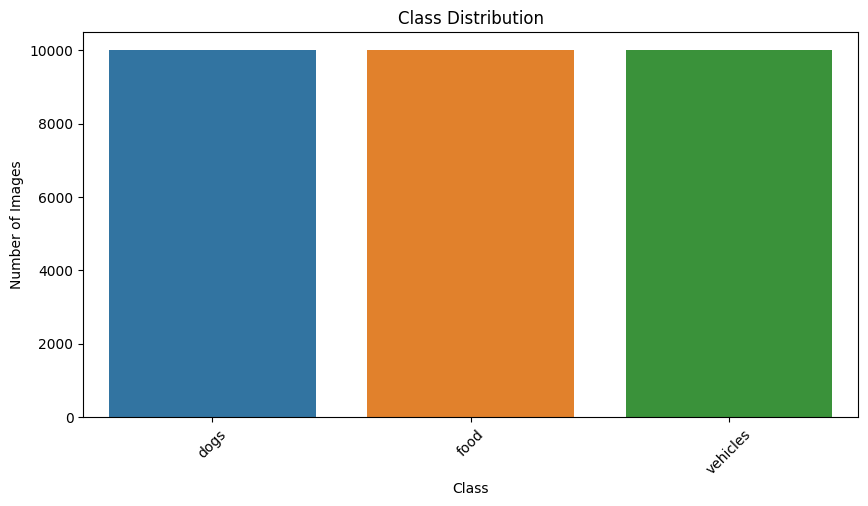

In [6]:
plt.figure(figsize=(10, 5))
sns.barplot(x='Class', y='Image Count', data=df)
plt.xticks(rotation=45)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.show()

It gives us a quick look at how the dataset is distributed across three categories: dogs, food, and vehicles. Each class has about 10,000 images, meaning the dataset is well-balanced. That’s great news because it ensures no single category dominates the model’s learning process, helping it make fair and accurate predictions across all three groups.

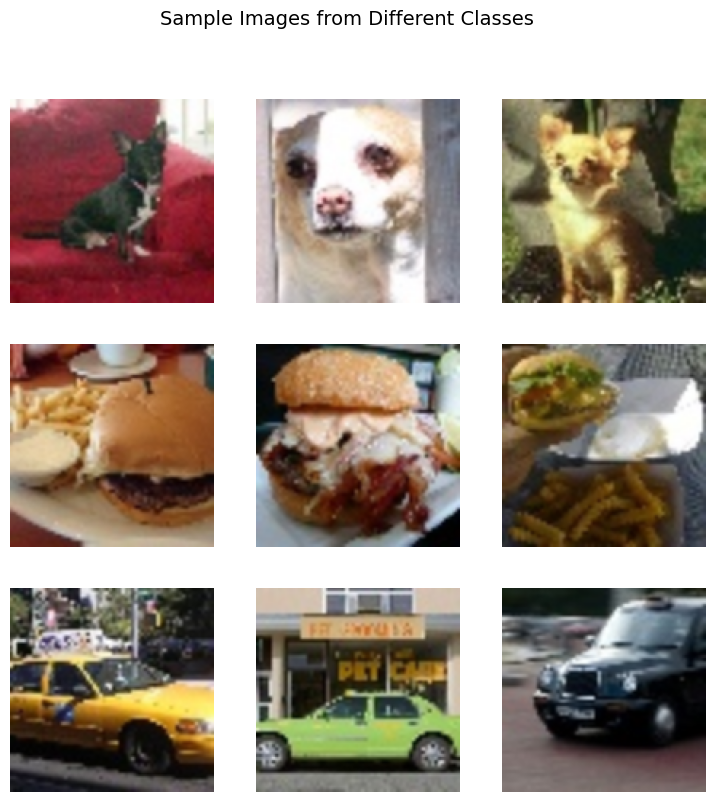

In [7]:
def show_images_grid(dataset, num_classes=3, samples_per_class=3):
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class * 3, num_classes * 3))
    class_indices = {i: [] for i in range(len(class_names))}

    for idx, (_, label) in enumerate(dataset):
        if len(class_indices[label]) < samples_per_class:
            class_indices[label].append(idx)

    for row, (class_id, indices) in enumerate(class_indices.items()):
        if row >= num_classes:
            break

        for col, idx in enumerate(indices):
            img, _ = dataset[idx]
            img = img.permute(1, 2, 0).numpy()
            axes[row, col].imshow(img)
            axes[row, col].axis("off")
            if col == 0:
                axes[row, col].set_ylabel(class_names[class_id], fontsize=12)

    plt.suptitle("Sample Images from Different Classes", fontsize=14)
    plt.show()

show_images_grid(dataset)

This image grid gives us a quick sneak peek at the dataset, showing examples from three different categories: dogs, food, and vehicles. The top row has dogs, the middle row is all about burgers and fries, and the bottom row features different types of cars. This kind of visualization is super useful because it helps us make sure the images are clear, diverse, and properly labeled before we dive into training a model.

C:\Users\Shishir\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Shishir\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\Shishir\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Shishir\AppData\Roaming\Python\Python311\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed

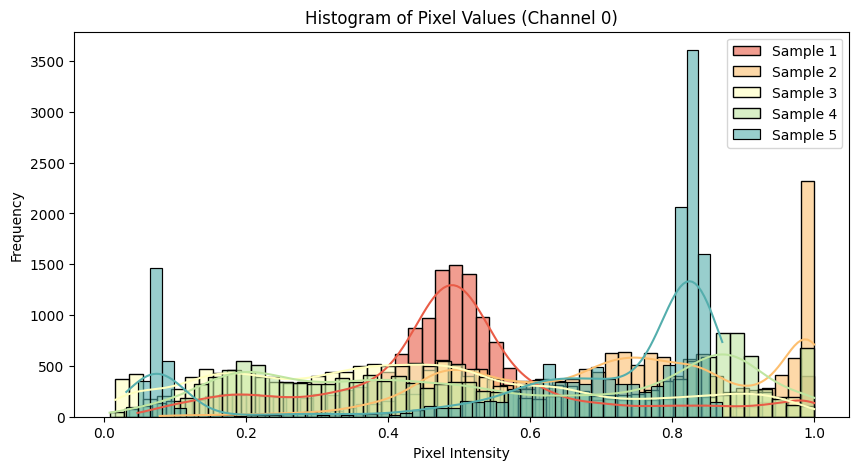

In [8]:
def plot_pixel_histogram(dataset, num_samples=5, channel=0):
    plt.figure(figsize=(10, 5))
    colors = sns.color_palette("Spectral",num_samples)
    
    for i in range(num_samples):
        img, _ = dataset[i]
        img_np = img[channel].numpy().flatten()
        sns.histplot(img_np, bins=50, kde=True, alpha=0.6, 
                     label=f"Sample {i+1}", color=colors[i])
    
    plt.title(f"Histogram of Pixel Values (Channel {channel})")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

plot_pixel_histogram(dataset)


It shows how pixel intensity values are distributed in the first color channel for five different image samples. Each sample has its own color, with bars representing how often certain intensity values appear. The smooth lines help show the overall trend of the data. You can see that some intensity levels are much more common than others, creating noticeable peaks. This gives a sense of the brightness patterns in the images and how they differ from one sample to another.

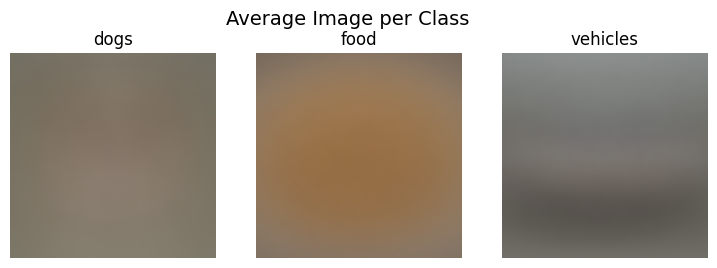

In [9]:
def compute_average_images(dataset):
    class_sums = {i: torch.zeros_like(dataset[0][0]) for i in range(len(class_names))}
    class_counts = Counter(dataset.targets)

    for img, label in dataset:
        class_sums[label] += img

    class_averages = {label: (class_sums[label] / class_counts[label]) for label in class_sums}

    fig, axes = plt.subplots(1, len(class_averages), figsize=(len(class_averages) * 3, 3))
    for i, (label, avg_img) in enumerate(class_averages.items()):
        avg_img = avg_img.permute(1, 2, 0).numpy()
        axes[i].imshow(avg_img)
        axes[i].set_title(class_names[label])
        axes[i].axis("off")

    plt.suptitle("Average Image per Class", fontsize=14)
    plt.show()

compute_average_images(dataset)

This image gives a blurry, averaged-out look at what each category—dogs, food, and vehicles—tends to look like. By blending multiple images together, we lose the details but keep the overall colors and textures. You can see that food has a warmer, brownish tone, while vehicles lean toward grays.

3. Preprocess the dataset.

In [10]:
add_norm_transform = transforms.Compose([
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

"""
mean=[0.4914, 0.4822, 0.4465],
            std=[0.2023, 0.1994, 0.2010]
"""

dataset.transform = transforms.Compose([
    dataset.transform,
    add_norm_transform
])
targets = torch.LongTensor(dataset.targets)

4. Split the dataset into training, testing, and validation sets.

In [11]:
indices = np.arange(len(dataset))
train_idx, test_val_idx = train_test_split(indices, test_size=0.3, stratify=dataset.targets, random_state=42)
val_idx, test_idx = train_test_split(test_val_idx, test_size=0.5, stratify=[dataset.targets[i] for i in test_val_idx], random_state=42)
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print(f"Training set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")
print(f"Test set: {len(test_dataset)} images")

Training set: 21000 images
Validation set: 4500 images
Test set: 4500 images


## Step 2: Implementing VGG

1. Implement the VGG-16 (Version C) architecture.

In [12]:
class VGG_16_model(nn.Module):

    def __init__(self, num_classes=3):
        super(VGG_16_model, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 4 * 4, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x


In [13]:
def xavier(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

def kaiming(m):
    if isinstance(m, nn.Conv2d):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [14]:
def run_an_epoch(model, data_loader, criterion, optimizer, device):
    model.train()
    runningLoss = 0.0
    runningCorrects = 0

    for inputs, labels in data_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        _, preds = torch.max(outputs, 1)
        runningLoss += loss.item() * inputs.size(0)
        runningCorrects += torch.sum(preds == labels.data)

    epoch_loss = runningLoss / len(data_loader.dataset)
    epoch_acc = runningCorrects.double() / len(data_loader.dataset)
    return epoch_loss, epoch_acc


In [15]:
def evaluate_an_epoch(model, data_loader, criterion, device):
    model.eval()
    runningLoss = 0.0
    runningCorrects = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            runningLoss += loss.item() * inputs.size(0)
            runningCorrects += torch.sum(preds == labels.data)

    epoch_loss = runningLoss / len(data_loader.dataset)
    epoch_acc = runningCorrects.double() / len(data_loader.dataset)
    return epoch_loss, epoch_acc


In [16]:
def train_function(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        print("-" * 10)
        train_loss, train_acc = run_an_epoch(model, train_loader, criterion, optimizer, device)
        scheduler.step()
        val_loss, val_acc = evaluate_an_epoch(model, val_loader, criterion, device)
        print(f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f}")
        print(f"Val   Loss: {val_loss:.4f} Acc: {val_acc:.4f}\n")
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    print(f"Best val Acc: {best_acc:.4f}\n")
    model.load_state_dict(best_model_wts)
    return model


In [17]:
def test_function(model, test_loader, device):
    model.eval()
    runningCorrects = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            X, preds = torch.max(outputs, 1)
            runningCorrects += torch.sum(preds == labels.data)

    test_acc = runningCorrects.double() / len(test_loader.dataset)
    print(f"Test Accuracy: {test_acc:.4f}")
    return test_acc

In [18]:
def create_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader, test_loader

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
number_classes = len(class_names)
optimizer_list = ['SGD', 'Adam', 'AdamW']
batch_size = [32, 64]
xavier_results = []
print("Xavier weight initialization:")

for opt_name in optimizer_list:

    for b_size in batch_size:
        print(f"Present configuration: Weights initialization = Xavier, Optimizer = {opt_name}, Batch Size = {b_size}")
        train_loader, val_loader, test_loader = create_dataloaders(b_size)
        model = VGG_16_model(num_classes=number_classes).to(device)
        model.apply(xavier)
        criterion = nn.CrossEntropyLoss()
        if opt_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
        elif opt_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        elif opt_name == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-4)
        scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.1)
        start_time = time.time()
        trained_model = train_function(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10)
        total_time = time.time() - start_time
        avg_epoch_time = total_time / 10
        print(f"Average time per epoch: {avg_epoch_time:.2f} seconds")
        test_acc = test_function(trained_model, test_loader, device)
        print("\n")
        xavier_results.append({
            'weight_init': 'Xavier',
            'optimizer': opt_name,
            'batch_size': b_size,
            'avg_epoch_time': avg_epoch_time,
            'test_accuracy': test_acc.item()
        })

print("Summary of Xavier results:")
for res in xavier_results:
    print(res)

Using device: cpu
Xavier weight initialization:
Present configuration: Weights initialization = Xavier, Optimizer = SGD, Batch Size = 32
Epoch 1/10
----------


KeyboardInterrupt: 

In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
num_classes = len(class_names)
optimizer_list = ['SGD', 'Adam', 'AdamW']
batch_size = [32, 64]
kaiming_results = []
print("Kaiming weight initialization")

for opt_name in optimizer_list:

    for b_size in batch_size:
        print(f"Present configuration: Weight initialization = Kaiming, Optimizer = {opt_name}, Batch Size = {b_size}")
        train_loader, val_loader, test_loader = create_dataloaders(b_size)
        model = VGG_16_model(num_classes=num_classes).to(device)
        model.apply(kaiming)
        criterion = nn.CrossEntropyLoss()
        if opt_name == 'SGD':
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
        elif opt_name == 'Adam':
            optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
        elif opt_name == 'AdamW':
            optimizer = optim.AdamW(model.parameters(), lr=0.01, weight_decay=5e-4)
        scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.1)
        start_time = time.time()
        trained_model = train_function(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10)
        total_time = time.time() - start_time
        avg_epoch_time = total_time / 10
        print(f"Average time per epoch: {avg_epoch_time:.2f} seconds")
        test_acc = test_function(trained_model, test_loader, device)
        print("\n")
        kaiming_results.append({
            'weight_init': 'Kaiming',
            'optimizer': opt_name,
            'batch_size': b_size,
            'avg_epoch_time': avg_epoch_time,
            'test_accuracy': test_acc.item()
        })

print("Summary of Kaiming results:")
for res in kaiming_results:
    print(res)

Using device: cpu
Kaiming weight initialization
Present configuration: Weight initialization = Kaiming, Optimizer = SGD, Batch Size = 32
Epoch 1/10
----------


KeyboardInterrupt: 

2. Use dropout and learning rate scheduler. Experiment with weight initialization strategies.

In [20]:
### ADD YOUR CODE HERE ###

3. Train your VGG-16 model.

In [21]:
### ADD YOUR CODE HERE ###

### Base Model(Model with highest accuracy obtained in hyperparameter tuning)

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
num_classes = len(class_names)
b_size = 32
train_loader, val_loader, test_loader = create_dataloaders(b_size)
model = VGG_16_model(num_classes=num_classes).to(device)
model.apply(kaiming)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[15, 25], gamma=0.1)
start_time = time.time()
trained_model = train_function(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10)
total_time = time.time() - start_time
avg_epoch_time = total_time / 30
print(f"Average time per epoch: {avg_epoch_time:.2f} seconds")
test_acc = test_function(trained_model, test_loader, device)
print("\n")
print("Test Accuracy:", test_acc)

Using device: cpu
Epoch 1/10
----------


KeyboardInterrupt: 

4. Apply regularization and overfitting prevention techniques.

In [ ]:
def kaiming(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [ ]:
def create_dataloaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
    return train_loader, val_loader, test_loader

In [25]:
def mixup_function(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.0
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

In [26]:
def run_an_epoch(model, dataloader, criterion, optimizer, device, use_mixup=False, mixup_alpha=1.0):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        if use_mixup:
            inputs, targets_a, targets_b, lam = mixup_function(inputs, labels, mixup_alpha)
            outputs = model(inputs)
            loss = lam * criterion(outputs, targets_a) + (1 - lam) * criterion(outputs, targets_b)
            _, preds = torch.max(outputs, 1)
            correct = lam * (preds == targets_a).float() + (1 - lam) * (preds == targets_b).float()
        else:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        if use_mixup:
            running_corrects += torch.sum(correct)
        else:
            running_corrects += torch.sum(preds == labels.data)
        total += inputs.size(0)

    return running_loss / total, running_corrects.double() / total

In [27]:
def evaluate_an_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0

    with torch.no_grad():

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total += inputs.size(0)

    return running_loss / total, running_corrects.double() / total

In [28]:
def test_model_with_all_the_metrics(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    total = 0
    all_labels, all_preds = [], []

    with torch.no_grad():

        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
            total += inputs.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    return running_loss / total, running_corrects.double() / total, all_labels, all_preds

In [29]:
def plot_training(epochs, train_vals, val_vals, ylabel, title, filename):
    plt.figure()
    plt.plot(epochs, train_vals, label="Train")
    plt.plot(epochs, val_vals, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.savefig(filename)
    plt.show()

In [30]:
def plot_confusion(all_labels, all_preds, method_name):
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(f"Confusion Matrix ({method_name})")
    plt.savefig(f"{method_name}_confusion_matrix.svg")
    plt.show()
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='weighted')
    print(f"{method_name} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

In [31]:
def show_misclassified_images(model, dataloader, device, method_name):
    misclassified_images, misclassified_true, misclassified_pred = [], [], []
    model.eval()

    for inputs, labels in dataloader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        for i in range(inputs.size(0)):
            if preds[i] != labels[i]:
                misclassified_images.append(inputs[i].cpu())
                misclassified_true.append(labels[i].cpu().item())
                misclassified_pred.append(preds[i].cpu().item())

        if len(misclassified_images) >= 5:
            break

    plt.figure(figsize=(12,6))

    for i in range(min(5, len(misclassified_images))):
        image = misclassified_images[i].permute(1, 2, 0).numpy()
        plt.subplot(1,5,i+1)
        plt.imshow(image)
        plt.title(f"True: {class_names[misclassified_true[i]]}\nPred: {class_names[misclassified_pred[i]]}")
        plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"{method_name}_misclassified.svg")
    plt.show()


In [37]:
def train_with_image_augmentation(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    writer = SummaryWriter(log_dir="runs/experiment_augmentation")
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        t_loss, t_acc = run_an_epoch(model, train_loader, criterion, optimizer, device, use_mixup=False)
        v_loss, v_acc = evaluate_an_epoch(model, val_loader, criterion, device)
        scheduler.step()
        train_losses.append(t_loss)
        train_accs.append(t_acc.item())
        val_losses.append(v_loss)
        val_accs.append(v_acc.item())
        writer.add_scalar("Augmentation/Train Loss", t_loss, epoch)
        writer.add_scalar("Augmentation/Train Accuracy", t_acc, epoch)
        writer.add_scalar("Augmentation/Validation Loss", v_loss, epoch)
        writer.add_scalar("Augmentation/Validation Accuracy", v_acc, epoch)
        print(f"(Augmentation) Epoch {epoch+1}/{num_epochs} -- Train Loss: {t_loss:.4f}, Train Acc: {t_acc:.4f}, Val Loss: {v_loss:.4f}, Val Acc: {v_acc:.4f}")
    
    writer.close()
    return model, train_losses, train_accs, val_losses, val_accs

In [33]:
def train_with_early_stopping_method(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=20, patience=3):
    writer = SummaryWriter(log_dir="runs/experiment_earlystopping")
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        t_loss, t_acc = run_an_epoch(model, train_loader, criterion, optimizer, device, use_mixup=False)
        v_loss, v_acc = evaluate_an_epoch(model, val_loader, criterion, device)
        scheduler.step()
        train_losses.append(t_loss)
        train_accs.append(t_acc.item())
        val_losses.append(v_loss)
        val_accs.append(v_acc.item())
        writer.add_scalar("EarlyStopping/Train Loss", t_loss, epoch)
        writer.add_scalar("EarlyStopping/Train Accuracy", t_acc, epoch)
        writer.add_scalar("EarlyStopping/Validation Loss", v_loss, epoch)
        writer.add_scalar("EarlyStopping/Validation Accuracy", v_acc, epoch)
        print(f"(EarlyStopping) Epoch {epoch+1}/{num_epochs} -- Train Loss: {t_loss:.4f}, Train Acc: {t_acc:.4f}, Val Loss: {v_loss:.4f}, Val Acc: {v_acc:.4f}")
        if v_loss < best_val_loss:
            best_val_loss = v_loss
            best_model_wts = copy.deepcopy(model.state_dict())
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    writer.close()
    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accs, val_losses, val_accs

In [34]:
def train_with_mixup_method(model, train_loader, val_loader, criterion, optimizer, scheduler, device, num_epochs=10, mixup_alpha=1.0):
    writer = SummaryWriter(log_dir="runs/experiment_mixup")
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(num_epochs):
        t_loss, t_acc = run_an_epoch(model, train_loader, criterion, optimizer, device, use_mixup=True, mixup_alpha=mixup_alpha)
        v_loss, v_acc = evaluate_an_epoch(model, val_loader, criterion, device)
        scheduler.step()
        train_losses.append(t_loss)
        train_accs.append(t_acc.item())
        val_losses.append(v_loss)
        val_accs.append(v_acc.item())
        writer.add_scalar("Mixup/Train Loss", t_loss, epoch)
        writer.add_scalar("Mixup/Train Accuracy", t_acc, epoch)
        writer.add_scalar("Mixup/Validation Loss", v_loss, epoch)
        writer.add_scalar("Mixup/Validation Accuracy", v_acc, epoch)
        print(f"(Mixup) Epoch {epoch+1}/{num_epochs} -- Train Loss: {t_loss:.4f}, Train Acc: {t_acc:.4f}, Val Loss: {v_loss:.4f}, Val Acc: {v_acc:.4f}")
    
    writer.close()
    return model, train_losses, train_accs, val_losses, val_accs

In [35]:
batch_size = 32
train_loader, val_loader, test_loader = create_dataloaders(batch_size)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
num_classes = len(class_names) 

Using device: cpu


In [38]:
print("\n=== Experiment 1: Image Augmentation Only ===")
aug_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(128, scale=(0.8, 1.0)),
    transforms.ToTensor()
])
train_dataset.transform = aug_transforms
model_augmentation = VGG_16_model(num_classes=num_classes).to(device)
model_augmentation.apply(kaiming)
optimizer_aug = optim.SGD(model_augmentation.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler_aug = lr_scheduler.MultiStepLR(optimizer_aug, milestones=[15, 25], gamma=0.1)
model_augmentation, train_losses_aug, train_accs_aug, val_losses_aug, val_accs_aug = train_with_image_augmentation(
    model_augmentation, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_aug, scheduler_aug, device, num_epochs=10
)
test_loss_aug, test_acc_aug, all_labels_aug, all_preds_aug = test_model_with_all_the_metrics(model_augmentation, test_loader, nn.CrossEntropyLoss(), device)
print(f"(Augmentation) Test Loss: {test_loss_aug:.4f}, Test Acc: {test_acc_aug:.4f}")
epochs_range_aug = range(1, len(train_losses_aug)+1)
plot_training(epochs_range_aug, train_accs_aug, val_accs_aug, "Accuracy", "Train vs Validation Accuracy (Augmentation)", "aug_accuracy_plot.svg")
plot_training(epochs_range_aug, train_losses_aug, val_losses_aug, "Loss", "Train vs Validation Loss (Augmentation)", "aug_loss_plot.svg")
plot_confusion(all_labels_aug, all_preds_aug, "Augmentation")
show_misclassified_images(model_augmentation, test_loader, device, "Augmentation")


=== Experiment 1: Image Augmentation Only ===


KeyboardInterrupt: 

In [39]:
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("\n=== Experiment 2: Early Stopping Only ===")
basic_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])
train_dataset.transform = basic_transform
model_es = VGG_16_model(num_classes=num_classes).to(device)
model_es.apply(kaiming)
optimizer_es = optim.SGD(model_es.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler_es = lr_scheduler.MultiStepLR(optimizer_es, milestones=[15, 25], gamma=0.1)
model_es, train_losses_es, train_accs_es, val_losses_es, val_accs_es = train_with_early_stopping_method(
    model_es, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_es, scheduler_es, device, num_epochs=10, patience=3
)
test_loss_es, test_acc_es, all_labels_es, all_preds_es = test_model_with_all_the_metrics(model_es, test_loader, nn.CrossEntropyLoss(), device)
print(f"(Early Stopping) Test Loss: {test_loss_es:.4f}, Test Acc: {test_acc_es:.4f}")
epochs_range_es = range(1, len(train_losses_es)+1)
plot_training(epochs_range_es, train_accs_es, val_accs_es, "Accuracy", "Train vs Validation Accuracy (Early Stopping)", "earlystop_accuracy_plot.svg")
plot_training(epochs_range_es, train_losses_es, val_losses_es, "Loss", "Train vs Validation Loss (Early Stopping)", "earlystop_loss_plot.svg")
plot_confusion(all_labels_es, all_preds_es, "EarlyStopping")
show_misclassified_images(model_es, test_loader, device, "EarlyStopping")


=== Experiment 2: Early Stopping Only ===


KeyboardInterrupt: 

In [40]:
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("\n=== Experiment 3: Mixup Only ===")
train_dataset.transform = basic_transform
model_mix = VGG_16_model(num_classes=num_classes).to(device)
model_mix.apply(kaiming)
optimizer_mix = optim.SGD(model_mix.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler_mix = lr_scheduler.MultiStepLR(optimizer_mix, milestones=[15, 25], gamma=0.1)
model_mix, train_losses_mix, train_accs_mix, val_losses_mix, val_accs_mix = train_with_mixup_method(
    model_mix, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_mix, scheduler_mix, device, num_epochs=10, mixup_alpha=1.0
)
test_loss_mix, test_acc_mix, all_labels_mix, all_preds_mix = test_model_with_all_the_metrics(model_mix, test_loader, nn.CrossEntropyLoss(), device)
print(f"(Mixup) Test Loss: {test_loss_mix:.4f}, Test Acc: {test_acc_mix:.4f}")
epochs_range_mix = range(1, len(train_losses_mix)+1)
plot_training(epochs_range_mix, train_accs_mix, val_accs_mix, "Accuracy", "Train vs Validation Accuracy (Mixup)", "mixup_accuracy_plot.svg")
plot_training(epochs_range_mix, train_losses_mix, val_losses_mix, "Loss", "Train vs Validation Loss (Mixup)", "mixup_loss_plot.svg")
plot_confusion(all_labels_mix, all_preds_mix, "Mixup")
show_misclassified_images(model_mix, test_loader, device, "Mixup")


=== Experiment 3: Mixup Only ===


KeyboardInterrupt: 

5. Evaluation and analysis.

In [23]:
### ADD YOUR CODE HERE ###

6. Save the weights of the trained network.

In [41]:
train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
print("\n=== Final Model: Early Stopping Only ===")
basic_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor()
])
train_dataset.transform = basic_transform
model_es = VGG_16_model(num_classes=num_classes).to(device)
model_es.apply(kaiming)
optimizer_es = optim.SGD(model_es.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
scheduler_es = lr_scheduler.MultiStepLR(optimizer_es, milestones=[15, 25], gamma=0.1)
model_es, train_losses_es_vgg, train_accs_es_vgg, val_losses_es_vgg, val_accs_es_vgg = train_with_early_stopping_method(
    model_es, train_loader, val_loader, nn.CrossEntropyLoss(), optimizer_es, scheduler_es, device, num_epochs=10, patience=3
)
test_loss_es_vgg, test_acc_es_vgg, all_labels_es, all_preds_es = test_model_with_all_the_metrics(model_es, test_loader, nn.CrossEntropyLoss(), device)
print(f"(Early Stopping) Test Loss: {test_loss_es_vgg:.4f}, Test Acc: {test_acc_es_vgg:.4f}")
torch.save(model_es.state_dict(), "earlystopping_model_weights.pth")
print("Model weights saved to earlystopping_model_weights.pth")
epochs_range_es = range(1, len(train_losses_es_vgg)+1)
plot_training(epochs_range_es, train_accs_es_vgg, val_accs_es_vgg, "Accuracy", "Train vs Validation Accuracy (Early Stopping)", "earlystop_accuracy_plot.svg")
plot_training(epochs_range_es, train_losses_es_vgg, val_losses_es_vgg, "Loss", "Train vs Validation Loss (Early Stopping)", "earlystop_loss_plot.svg")
plot_confusion(all_labels_es, all_preds_es, "EarlyStopping")
show_misclassified_images(model_es, test_loader, device, "EarlyStopping")



=== Final Model: Early Stopping Only ===


KeyboardInterrupt: 

## Step 3: Implementing ResNet

In [2]:
                                    ##-----------------------------##
                                    # Sets seed for reproducibility #
                                    ##-----------------------------##

seed = 42
torch.manual_seed(seed)
random.seed(seed)
np.random.seed(seed)

1. Implement residual blocks of ResNet.

In [3]:
#Initialize the residual block as a class
class ResBlock(nn.Module):

    expansion = 1                             #Used for knowing the output dim in multi-layers
    
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3,       #1st Conv Layer
                               stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x                                      #Saves input for residual connection

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        #Case were dimension differs
        if self.downsample is not None:
            identity = self.downsample(x)

        #The Residual connection
        out += identity
        out = self.relu(out)
        return out

2. Assemble the ResNet-18 architecture.

In [4]:
                        ##--------------------------------------------------------##
                        # Create the Resnet architecture using the residual blocks #
                        ##--------------------------------------------------------##

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=3, init_method='he'):
        super(ResNet, self).__init__()
        self.in_channels = 64
        self.init_method = init_method
        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 64,  layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

        #Helps initialize weights instead of random initialization
        self._initialize_weights()

    def _make_layer(self, block, out_channels, blocks, stride):
        
        downsample = None              #Helps downsample if the input and output dimensions does not match
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)
    
    #Based on input type mentioned initializes weights instead of random weight init
    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                if self.init_method == 'he':
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                elif self.init_method == 'xavier':
                    nn.init.xavier_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        #Passes through the four layers of residual blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

def resnet18(num_classes=3, init_method='he'):
    return ResNet(ResBlock, [2, 2, 2, 2], num_classes=num_classes, init_method=init_method)

3. Train the ResNet-18 model.

In [5]:
#Helper functions to train the model in a loop

#Helps take the optimizer for init
def get_optimizer(model, optimizer_name, lr):
    if optimizer_name.lower() == 'sgd':
        return optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    elif optimizer_name.lower() == 'adam':
        return optim.Adam(model.parameters(), lr=lr)
    elif optimizer_name.lower() == 'rmsprop':
        return optim.RMSprop(model.parameters(), lr=lr)
    else:
        raise ValueError(f"Unsupported optimizer: {optimizer_name}")

        
#Main train, test modularized function
def train_and_evaluate(model, train_loader, val_loader, device, config, exp_id):
    
    writer = SummaryWriter(log_dir=f'runs/exp_{exp_id}_{time.strftime("%Y%m%d-%H%M%S")}')
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(model, config['optimizer'], config['learning_rate'])
    scheduler = lr_scheduler.StepLR(optimizer, step_size=config['lr_step'], gamma=config['lr_gamma'])
    
    model = model.to(device)
    best_val_acc = 0.0
    best_model_wts = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(config['num_epochs']):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_loss = running_loss / total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        #Validation
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = running_loss / total
        val_acc = correct / total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        writer.add_scalar('Loss/Train', train_loss, epoch)
        writer.add_scalar('Loss/Validation', val_loss, epoch)
        writer.add_scalar('Accuracy/Train', train_acc, epoch)
        writer.add_scalar('Accuracy/Validation', val_acc, epoch)
        
        print(f"Exp {exp_id} | Epoch {epoch+1}/{config['num_epochs']} | "
              f"Train Loss: {train_loss:.4f} Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f} Acc: {val_acc:.4f}")
        
        scheduler.step()
    
    writer.close()
    
    #Test set eval
    model.eval()
    test_running_loss = 0.0
    correct = 0
    total = 0
    test_all_preds = []
    test_all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            test_all_preds.extend(preds.cpu().numpy())
            test_all_labels.extend(labels.cpu().numpy())
    test_loss = test_running_loss / total
    test_acc = correct / total
    test_cm = confusion_matrix(test_all_labels, test_all_preds)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_all_labels, test_all_preds, average='weighted')
    test_misclassified = total - sum(np.array(test_all_preds) == np.array(test_all_labels))
    print(f"\nExp {exp_id} Test Set Evaluation:")
    print(f"Test Loss: {test_loss:.4f}  Test Acc: {test_acc:.4f}")
    print(f"Confusion Matrix:\n{test_cm}")
    print(f"Precision: {test_precision:.4f}  Recall: {test_recall:.4f}  F1: {test_f1:.4f}")
    print(f"Misclassified: {test_misclassified}/{total}")
    
    return {
        'history': history,
        'test_loss': test_loss,
        'test_acc': test_acc
    }

In [36]:
#A global config file
global_config = {
        'num_epochs': 10,
        'learning_rate': 0.001,
        'lr_step': 7,
        'lr_gamma': 0.1
    }
    
#Hyperparameters to loop over
weight_inits = ['he', 'xavier']       
optimizers = ['sgd', 'adam', 'rmsprop'] 
batch_sizes = [32, 64]                

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

experiment_results = {}
exp_counter = 1

for init_method, optimizer_name, batch_size in product(weight_inits, optimizers, batch_sizes):
    exp_id = f"exp{exp_counter}-{init_method}_opt-{optimizer_name}_bs-{batch_size}"
    print(f"\nStarting {exp_id}")

    config = global_config.copy()
    config['init_method'] = init_method
    config['optimizer'] = optimizer_name
    config['batch_size'] = batch_size

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    model = resnet18(num_classes=3, init_method=init_method)

    result = train_and_evaluate(model, train_loader, val_loader, device, config, exp_id)
    experiment_results[exp_id] = result
    exp_counter += 1

Using device: cuda

Starting exp1-he_opt-sgd_bs-32
Exp exp1-he_opt-sgd_bs-32 | Epoch 1/10 | Train Loss: 0.5167 Acc: 0.7925 | Val Loss: 0.4212 Acc: 0.8409
Exp exp1-he_opt-sgd_bs-32 | Epoch 2/10 | Train Loss: 0.3789 Acc: 0.8530 | Val Loss: 0.3394 Acc: 0.8718
Exp exp1-he_opt-sgd_bs-32 | Epoch 3/10 | Train Loss: 0.3295 Acc: 0.8752 | Val Loss: 0.3086 Acc: 0.8873
Exp exp1-he_opt-sgd_bs-32 | Epoch 4/10 | Train Loss: 0.2912 Acc: 0.8910 | Val Loss: 0.3756 Acc: 0.8538
Exp exp1-he_opt-sgd_bs-32 | Epoch 5/10 | Train Loss: 0.2702 Acc: 0.8981 | Val Loss: 0.2690 Acc: 0.8982
Exp exp1-he_opt-sgd_bs-32 | Epoch 6/10 | Train Loss: 0.2491 Acc: 0.9065 | Val Loss: 0.3064 Acc: 0.8909
Exp exp1-he_opt-sgd_bs-32 | Epoch 7/10 | Train Loss: 0.2225 Acc: 0.9187 | Val Loss: 0.2453 Acc: 0.9149
Exp exp1-he_opt-sgd_bs-32 | Epoch 8/10 | Train Loss: 0.1755 Acc: 0.9357 | Val Loss: 0.2034 Acc: 0.9271
Exp exp1-he_opt-sgd_bs-32 | Epoch 9/10 | Train Loss: 0.1655 Acc: 0.9411 | Val Loss: 0.2004 Acc: 0.9267
Exp exp1-he_opt-sgd_bs

Exp exp7-xavier_opt-sgd_bs-32 | Epoch 4/10 | Train Loss: 0.2778 Acc: 0.8982 | Val Loss: 0.2978 Acc: 0.8924
Exp exp7-xavier_opt-sgd_bs-32 | Epoch 5/10 | Train Loss: 0.2496 Acc: 0.9067 | Val Loss: 0.2413 Acc: 0.9087
Exp exp7-xavier_opt-sgd_bs-32 | Epoch 6/10 | Train Loss: 0.2251 Acc: 0.9177 | Val Loss: 0.3046 Acc: 0.8873
Exp exp7-xavier_opt-sgd_bs-32 | Epoch 7/10 | Train Loss: 0.2013 Acc: 0.9279 | Val Loss: 0.2769 Acc: 0.9016
Exp exp7-xavier_opt-sgd_bs-32 | Epoch 8/10 | Train Loss: 0.1454 Acc: 0.9478 | Val Loss: 0.1820 Acc: 0.9322
Exp exp7-xavier_opt-sgd_bs-32 | Epoch 9/10 | Train Loss: 0.1336 Acc: 0.9530 | Val Loss: 0.1683 Acc: 0.9376
Exp exp7-xavier_opt-sgd_bs-32 | Epoch 10/10 | Train Loss: 0.1301 Acc: 0.9558 | Val Loss: 0.1693 Acc: 0.9398

Exp exp7-xavier_opt-sgd_bs-32 Test Set Evaluation:
Test Loss: 0.1562  Test Acc: 0.9416
Confusion Matrix:
[[1431   43   26]
 [  77 1396   27]
 [  58   32 1410]]
Precision: 0.9422  Recall: 0.9416  F1: 0.9417
Misclassified: 263/4500

Starting exp8-xavi

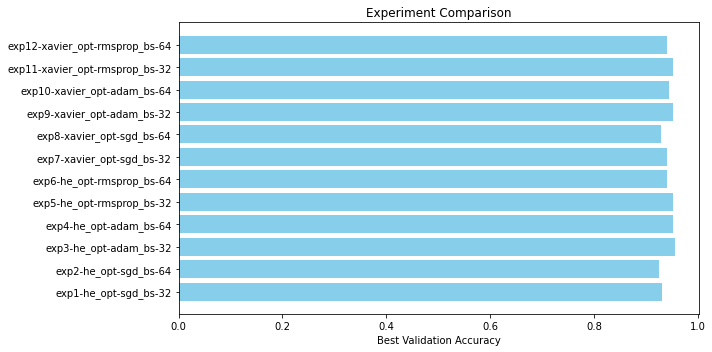


Summary of experiments:
exp1-he_opt-sgd_bs-32: Test Loss = 0.1824, Test Acc = 0.9320
exp2-he_opt-sgd_bs-64: Test Loss = 0.2072, Test Acc = 0.9253
exp3-he_opt-adam_bs-32: Test Loss = 0.1242, Test Acc = 0.9556
exp4-he_opt-adam_bs-64: Test Loss = 0.1359, Test Acc = 0.9520
exp5-he_opt-rmsprop_bs-32: Test Loss = 0.1328, Test Acc = 0.9520
exp6-he_opt-rmsprop_bs-64: Test Loss = 0.1634, Test Acc = 0.9402
exp7-xavier_opt-sgd_bs-32: Test Loss = 0.1562, Test Acc = 0.9416
exp8-xavier_opt-sgd_bs-64: Test Loss = 0.1912, Test Acc = 0.9296
exp9-xavier_opt-adam_bs-32: Test Loss = 0.1319, Test Acc = 0.9533
exp10-xavier_opt-adam_bs-64: Test Loss = 0.1476, Test Acc = 0.9456
exp11-xavier_opt-rmsprop_bs-32: Test Loss = 0.1433, Test Acc = 0.9518
exp12-xavier_opt-rmsprop_bs-64: Test Loss = 0.1647, Test Acc = 0.9402


In [37]:
exp_ids = list(experiment_results.keys())
best_accs = [experiment_results[exp]['test_acc'] for exp in exp_ids]
plt.figure(figsize=(10, 5))
plt.barh(exp_ids, best_accs, color='skyblue')
plt.xlabel('Best Validation Accuracy')
plt.title('Experiment Comparison')
plt.tight_layout()
plt.show()

print("\nSummary of experiments:")
for exp_id, res in experiment_results.items():
    print(f"{exp_id}: Test Loss = {res['test_loss']:.4f}, Test Acc = {res['test_acc']:.4f}")

### `Best Results:` 
`exp3-he_opt-adam_bs-32:` Test Loss = 0.1242, Test Acc = 0.9556

After succesful experiments, we found out ResNet with `He Initialization`, `Adam Optimizer` with a `batch size of 32`, gave us the most promising and best results overall. If observed, most of the 32 batch size experiments had a slight upper hand than the 64 ones, this is because of the model's ability to generalize better on the test set as for every 32 batch of images the internal parameters were updated. Thus, giving it better approximation on the data.

4. Apply regularization techniques.

Using device: cuda

Starting experiment: EarlyStopping
Exp ResNet_EarlyStopping | Epoch 1/15 - Train Loss: 0.4663, Train Acc: 0.8172, Val Loss: 0.3540, Val Acc: 0.8587
Exp ResNet_EarlyStopping | Epoch 2/15 - Train Loss: 0.3182, Train Acc: 0.8800, Val Loss: 0.4223, Val Acc: 0.8264
Exp ResNet_EarlyStopping | Epoch 3/15 - Train Loss: 0.2656, Train Acc: 0.9026, Val Loss: 0.2276, Val Acc: 0.9158
Exp ResNet_EarlyStopping | Epoch 4/15 - Train Loss: 0.2311, Train Acc: 0.9151, Val Loss: 0.2229, Val Acc: 0.9176
Exp ResNet_EarlyStopping | Epoch 5/15 - Train Loss: 0.2062, Train Acc: 0.9256, Val Loss: 0.1861, Val Acc: 0.9367
Exp ResNet_EarlyStopping | Epoch 6/15 - Train Loss: 0.1829, Train Acc: 0.9332, Val Loss: 0.1964, Val Acc: 0.9269
Exp ResNet_EarlyStopping | Epoch 7/15 - Train Loss: 0.1657, Train Acc: 0.9383, Val Loss: 0.1906, Val Acc: 0.9324
Exp ResNet_EarlyStopping | Epoch 8/15 - Train Loss: 0.1544, Train Acc: 0.9427, Val Loss: 0.2508, Val Acc: 0.9129
Exp ResNet_EarlyStopping | Epoch 9/15 - T

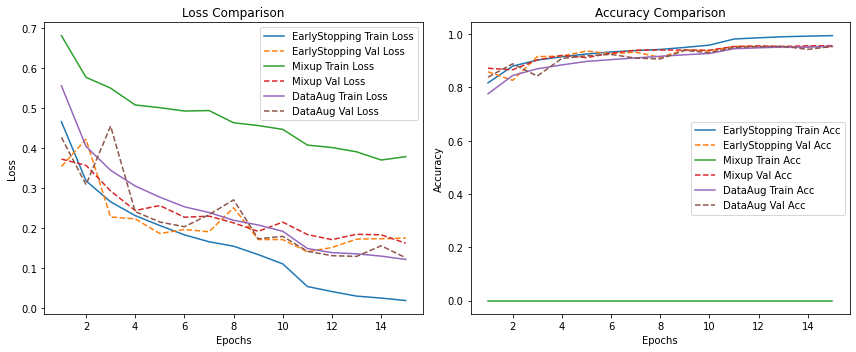

All experiments completed.


In [38]:
                                        # --------------------------- #
                                        # Reg Tech 1: Early Stopping  # 
                                        # --------------------------- #
        
class EarlyStopping:
    def __init__(self, patience=2, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            return False
        elif val_loss < self.best_loss - self.delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
            return self.early_stop

                                        # --------------------------- #
                                        #       Reg Tech 2: Mixup     # 
                                        # --------------------------- #
                    
                    
def mixup_data(x, y, alpha=1.0, use_cuda=True):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)


                                        # ----------------------------- #
                                        # Reg Tech 3: Data Augmentation # 
                                        # ----------------------------- #


def get_transforms(use_data_aug=False):
    if use_data_aug:
        train_transform = transforms.Compose([
            transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    else:
        train_transform = transforms.Compose([
            transforms.Resize((64, 64)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])
    test_transform = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])
    return train_transform, test_transform


#Dataloaders
def get_data_loaders(dataset_dir, batch_size, use_data_aug=False):
    train_transform, test_transform = get_transforms(use_data_aug)
    full_dataset = datasets.ImageFolder(root=dataset_dir, transform=train_transform)
    indices = np.arange(len(full_dataset))
    train_idx, test_val_idx = train_test_split(indices, test_size=0.3,
                                                stratify=full_dataset.targets, random_state=42)
    val_idx, test_idx = train_test_split(test_val_idx, test_size=0.5,
                                         stratify=[full_dataset.targets[i] for i in test_val_idx], random_state=42)
    train_dataset = Subset(full_dataset, train_idx)
    val_dataset_full = datasets.ImageFolder(root=dataset_dir, transform=test_transform)
    test_dataset_full = datasets.ImageFolder(root=dataset_dir, transform=test_transform)
    val_dataset = Subset(val_dataset_full, val_idx)
    test_dataset = Subset(test_dataset_full, test_idx)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
    return train_loader, val_loader, test_loader


def train_and_evaluate(model, train_loader, val_loader, test_loader, device, config, exp_id):
    writer = SummaryWriter(log_dir=f"runs/exp_{exp_id}_{time.strftime('%Y%m%d-%H%M%S')}")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=config['learning_rate'])
    scheduler = lr_scheduler.StepLR(optimizer, step_size=config['lr_step'], gamma=config['lr_gamma'])
    
    early_stopping = EarlyStopping(patience=config['patience']) if config['use_early_stopping'] else None
    
    model = model.to(device)
    best_model_wts = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(config['num_epochs']):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            if config['use_mixup']:
                inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=config['mixup_alpha'], use_cuda=(device.type=='cuda'))
                outputs = model(inputs)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            if not config['use_mixup']:
                correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_loss = running_loss / total
        train_acc = correct / total if not config['use_mixup'] else 0
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Accuracy/Train", train_acc, epoch)
        
        # Evaluate on validation set
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        writer.add_scalar("Loss/Val", val_loss, epoch)
        writer.add_scalar("Accuracy/Val", val_acc, epoch)
        
        print(f"Exp {exp_id} | Epoch {epoch+1}/{config['num_epochs']} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        scheduler.step()
        
        if config['use_early_stopping']:
            if early_stopping(val_loss, model):
                print("Early stopping triggered.")
                break
                
    writer.close()
    
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    test_all_preds = []
    test_all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
            test_all_preds.extend(preds.cpu().numpy())
            test_all_labels.extend(labels.cpu().numpy())
    test_loss = test_running_loss / test_total
    test_acc = test_correct / test_total
    test_cm = confusion_matrix(test_all_labels, test_all_preds)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_all_labels, test_all_preds, average='weighted')
    print(f"\nTest Evaluation for Exp {exp_id}:")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    print(f"Confusion Matrix:\n{test_cm}")
    print(f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
    
    return history

base_config = {
    'num_epochs': 15,
    'learning_rate': 0.001,
    'lr_step': 10,
    'lr_gamma': 0.1,
    'dataset_dir': 'cnn_dataset',  
    'batch_size': 32,
    'patience': 5,
    'mixup_alpha': 0.4
}

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

experiments = {
    "EarlyStopping": {
        **base_config,
        "use_early_stopping": True,
        "use_mixup": False,
        "use_data_aug": False  
    },
    "Mixup": {
        **base_config,
        "use_early_stopping": False,
        "use_mixup": True,
        "use_data_aug": False  
    },
    "DataAug": {
        **base_config,
        "use_early_stopping": False,
        "use_mixup": False,
        "use_data_aug": True   
    }
}

results = {}

for exp_name, config in experiments.items():
    print(f"\nStarting experiment: {exp_name}")
    train_loader, val_loader, test_loader = get_data_loaders(config['dataset_dir'], config['batch_size'], use_data_aug=config['use_data_aug'])
    model = resnet18(num_classes=3, init_method='he')
    exp_id = f"ResNet_{exp_name}"
    history = train_and_evaluate(model, train_loader, val_loader, test_loader, device, config, exp_id)
    results[exp_name] = history
    print(f"Experiment {exp_name} completed.\n")

    
plt.figure(figsize=(12, 5))

#Plots the Loss Comparison
plt.subplot(1, 2, 1)
for exp_name, history in results.items():
    epochs = range(1, len(history['train_loss']) + 1)
    plt.plot(epochs, history['train_loss'], label=f"{exp_name} Train Loss")
    plt.plot(epochs, history['val_loss'], linestyle="--", label=f"{exp_name} Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Comparison")
plt.legend()

#Plots the Accuracy Comparison
plt.subplot(1, 2, 2)
for exp_name, history in results.items():
    epochs = range(1, len(history['train_acc']) + 1)
    plt.plot(epochs, history['train_acc'], label=f"{exp_name} Train Acc")
    plt.plot(epochs, history['val_acc'], linestyle="--", label=f"{exp_name} Val Acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison")
plt.legend()

plt.tight_layout()
plt.show()

### `Best Results (After Regularization):` 
`ResNet_Mixup_init-he_opt-adam_bs-32_reg-mixup:` Test Loss: 0.1557, Test Acc: 0.9622

After applying 3 different regularization techniques, we ended with a higher accuracy than the base model using `mixup` of data as a regularization method. After observing the train loss and accuracy from the above plots, we can conclude that during the training period, the early stopping didn't help that much to generalize to the test sets, it instead overfitted model here because the number of epochs are really less to see its effectiveness. The same goes for data augmentation, it performed better than early stopping and showed very slight improvements.

Whereas, Mixup showed promising improvement in the test accuracy by better generalizing the data. If observed, the train acc is set to zero, this is because it's irrelevant as mixup creates mixes 2 or more class images and makes new classes. So, when observed it shows the highest train loss but this method helps generalize better due to its slight lesser confidence on the presented data, thus not ignoring multiple misclassified cases where the other models failed to do so.

In [13]:
                                    ##-----------------------------##
                                    # Best ResNet Model after tune  #
                                    ##-----------------------------##


def train_best_ResNet(model, train_loader, val_loader, test_loader, device, config, exp_id):
    writer = SummaryWriter(log_dir=f"runs/exp_{exp_id}_{time.strftime('%Y%m%d-%H%M%S')}")
    criterion = nn.CrossEntropyLoss()
    optimizer = get_optimizer(model, config['optimizer'], config['learning_rate'])
    scheduler = lr_scheduler.StepLR(optimizer, step_size=config['lr_step'], gamma=config['lr_gamma'])
    
    
    model = model.to(device)
    
    best_val_acc = 0.0
    best_model_wts = None
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
    
    for epoch in range(config['num_epochs']):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            if config['use_mixup']:
                inputs, targets_a, targets_b, lam = mixup_data(inputs, labels, alpha=config['mixup_alpha'], use_cuda=(device.type=='cuda'))
                outputs = model(inputs)
                loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)
            else:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            if not config['use_mixup']:
                correct += (preds == labels).sum().item()
            total += labels.size(0)
        train_loss = running_loss / total
        train_acc = correct / total if not config['use_mixup'] else 0
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Accuracy/Train", train_acc, epoch)
        
        # Validation phase
        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_loss = val_running_loss / val_total
        val_acc = val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        writer.add_scalar("Loss/Val", val_loss, epoch)
        writer.add_scalar("Accuracy/Val", val_acc, epoch)
        
        print(f"Exp {exp_id} | Epoch {epoch+1}/{config['num_epochs']} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        scheduler.step()
        
        # Save best model based on validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()
            save_path = f"best_model_exp_{exp_id}.pth"
            torch.save(best_model_wts, save_path)
    
    writer.close()
    
    # Evaluate on the untouched test set
    model.eval()
    test_running_loss = 0.0
    test_correct = 0
    test_total = 0
    test_all_preds = []
    test_all_labels = []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            test_correct += (preds == labels).sum().item()
            test_total += labels.size(0)
            test_all_preds.extend(preds.cpu().numpy())
            test_all_labels.extend(labels.cpu().numpy())
    test_loss = test_running_loss / test_total
    test_acc = test_correct / test_total
    test_cm = confusion_matrix(test_all_labels, test_all_preds)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(test_all_labels, test_all_preds, average='weighted')
    
    print(f"\nExp {exp_id} Test Evaluation:")
    print(f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")
    print(f"Precision: {test_precision:.4f}, Recall: {test_recall:.4f}, F1: {test_f1:.4f}")
    print("-"*50)
    
    # Plot confusion matrix with numbers
    plt.figure(figsize=(6, 5))
    plt.imshow(test_cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.colorbar()
    # Get class names from the test dataset (ImageFolder)
    test_dataset_full = datasets.ImageFolder(root=config['dataset_dir'], transform=get_transforms(use_data_aug=False)[1])
    classes = test_dataset_full.classes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    # Annotate the cells with the numbers
    for i in range(test_cm.shape[0]):
        for j in range(test_cm.shape[1]):
            plt.text(j, i, format(test_cm[i, j], 'd'),
                     horizontalalignment="center",
                     color="white" if test_cm[i, j] > test_cm.max()/2. else "black")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()

    # Identify misclassified examples
    misclassified_idx = [i for i, (p, t) in enumerate(zip(test_all_preds, test_all_labels)) if p != t]
    print(f"Misclassified examples: {len(misclassified_idx)} out of {test_total}")

    # Plot up to 9 misclassified examples with class names
    if misclassified_idx:
        plt.figure(figsize=(10, 10))
        count = 0
        # For display, use baseline transform
        _, display_transform = get_transforms(use_data_aug=False)
        test_dataset_full = datasets.ImageFolder(root=config['dataset_dir'], transform=display_transform)
        classes = test_dataset_full.classes
        # Get the test indices from our split (assuming test_loader.dataset.indices is available)
        _, _, test_loader_display = get_data_loaders(config['dataset_dir'], config['batch_size'], use_data_aug=False)
        test_indices = test_loader_display.dataset.indices
        test_images = [test_dataset_full[i][0] for i in test_indices]
        for idx in misclassified_idx[:9]:
            img = test_images[idx]
            true_label = test_all_labels[idx]
            pred_label = test_all_preds[idx]
            plt.subplot(3, 3, count+1)
            npimg = img.cpu().numpy()
            npimg = np.transpose(npimg, (1, 2, 0))
            # Denormalize for display
            npimg = np.clip(npimg * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406]), 0, 1)
            plt.imshow(npimg)
            plt.title(f"True: {classes[true_label]}, Pred: {classes[pred_label]}")
            plt.axis("off")
            count += 1
        plt.tight_layout()
        plt.show()
    
    return history, test_loss, test_acc

Exp Best_Model | Epoch 1/12 - Train Loss: 0.6885, Train Acc: 0.0000, Val Loss: 0.4152, Val Acc: 0.8440
Exp Best_Model | Epoch 2/12 - Train Loss: 0.5987, Train Acc: 0.0000, Val Loss: 0.3821, Val Acc: 0.8673
Exp Best_Model | Epoch 3/12 - Train Loss: 0.5571, Train Acc: 0.0000, Val Loss: 0.3203, Val Acc: 0.9118
Exp Best_Model | Epoch 4/12 - Train Loss: 0.5215, Train Acc: 0.0000, Val Loss: 0.4564, Val Acc: 0.8260
Exp Best_Model | Epoch 5/12 - Train Loss: 0.5143, Train Acc: 0.0000, Val Loss: 0.3505, Val Acc: 0.8836
Exp Best_Model | Epoch 6/12 - Train Loss: 0.4874, Train Acc: 0.0000, Val Loss: 0.2718, Val Acc: 0.9071
Exp Best_Model | Epoch 7/12 - Train Loss: 0.4991, Train Acc: 0.0000, Val Loss: 0.2240, Val Acc: 0.9376
Exp Best_Model | Epoch 8/12 - Train Loss: 0.4627, Train Acc: 0.0000, Val Loss: 0.2428, Val Acc: 0.9278
Exp Best_Model | Epoch 9/12 - Train Loss: 0.4603, Train Acc: 0.0000, Val Loss: 0.2172, Val Acc: 0.9360
Exp Best_Model | Epoch 10/12 - Train Loss: 0.4554, Train Acc: 0.0000, Val

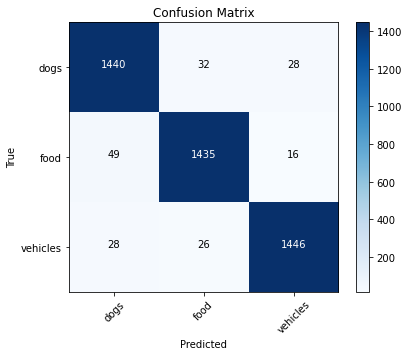

Misclassified examples: 179 out of 4500


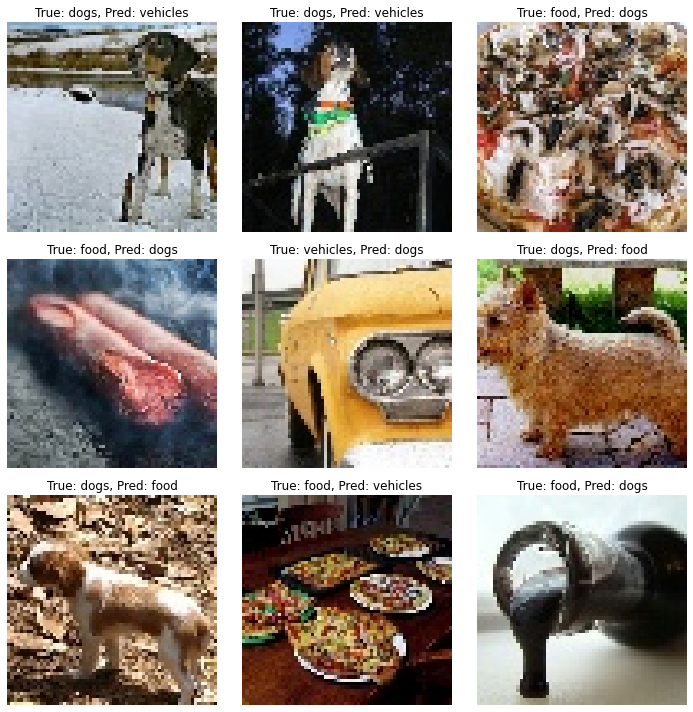

In [16]:
config = {
        'num_epochs': 12,
        'learning_rate': 0.001,
        'lr_step': 10,
        'lr_gamma': 0.1,
        'dataset_dir': 'cnn_dataset',  
        'optimizer': 'adam',
        'init_method': 'he',
        'batch_size': 32,
        'patience': 5,
        'mixup_alpha': 0.4,
        'use_early_stopping': False,  
        'use_mixup': True,            
        'use_data_aug': False         
    }
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_loader, val_loader, test_loader = get_data_loaders(config['dataset_dir'], config['batch_size'], use_data_aug=config['use_data_aug'])

model = resnet18(num_classes=3, init_method=config['init_method'])

exp_id = "Best_Model"
history, test_loss, test_acc = train_best_ResNet(model, train_loader, val_loader, test_loader, device, config, exp_id)

5. Evaluation and analysis.

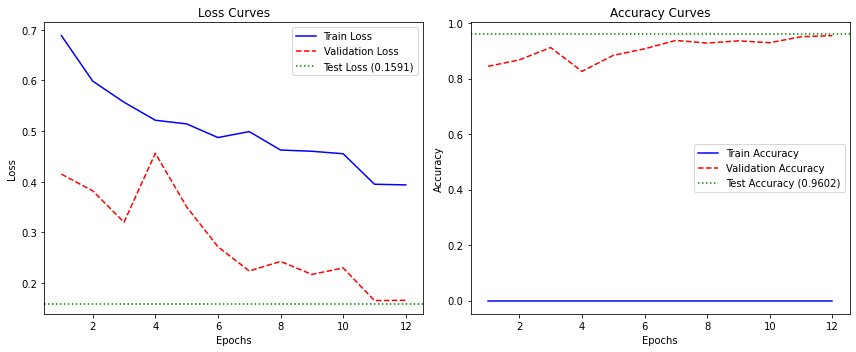

In [17]:
epochs = range(1, len(history['train_loss']) + 1)

# Plot Loss Curves
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
plt.plot(epochs, history['val_loss'], 'r--', label='Validation Loss')
plt.axhline(y=test_loss, color='g', linestyle=':', label=f'Test Loss ({test_loss:.4f})')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Plot Accuracy Curves
plt.subplot(1, 2, 2)
plt.plot(epochs, history['train_acc'], 'b-', label='Train Accuracy')
plt.plot(epochs, history['val_acc'], 'r--', label='Validation Accuracy')
plt.axhline(y=test_acc, color='g', linestyle=':', label=f'Test Accuracy ({test_acc:.4f})')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

## Step 4: Discussion and conclusion

1. Explain the theoretical concepts behind VGG and ResNet.

<span style='color:green'>### YOUR ANSWER ###</span>

2. Discuss the impact of regularization and optimization techniques.

<span style='color:green'>### YOUR ANSWER ###</span>

3. Analyze the results, including all required graphs and metrics.

<span style='color:green'>### YOUR ANSWER ###</span>

4. Summarize your findings and discuss the advantages of residual connections.

<span style='color:green'>### YOUR ANSWER ###</span>

5. References.

<span style='color:green'>### YOUR ANSWER ###</span>